# CV Coursework: Model 2: HOG & MLP on personal dataset

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)
- **CW Owner:** Mousuf C Zaman - Student No: 180021356

# Google Colab & Env Setup

In [ ]:
!pip install facenet-pytorch
!pip install opencv-python==4.5.5.64

import os
import sys
import numpy as np
import cv2
from collections import Counter
from matplotlib import patches
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color, exposure, img_as_ubyte
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import MiniBatchKMeans
from joblib import dump, load
from facenet_pytorch import MTCNN

from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '11 - University/Colab Notebooks/Computer Vision Lab/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

%load_ext autoreload
%autoreload 2

MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models')
sys.path.append(MODEL_PATH)

Classifier_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code/Classifier')
sys.path.append(Classifier_PATH)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Code', 'CW_Dataset', 'Models', 'CV CW Progress.gdoc', 'CV Report.docx', 'Other', 'Personal_Dataset', 'test_functions.ipynb', 'CV Demo Script.gdoc', 'v27_MLP_HOG_test_functions[COMPLETED].ipynb', 'v26_own_data_MLP_HOG_test_functions[COMPLETED].ipynb']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

# Identify path to zipped dataset
zip_path2 = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset/ownTest.zip')

# Copy it to Colab
!cp '{zip_path2}' .

# Unzip it
!yes|unzip -q ownTest.zip

# Delete zipped version from Colab (not from Drive)
!rm ownTest.zip


##################################################################
# Loading data function

def load_images_and_labels(train_path, test_path, own_test_path):
    images = []
    labels = []
    own_images = []
    own_labels = []

    # Load images and labels from train folder
    train_images_path = os.path.join(train_path, 'images')
    train_labels_path = os.path.join(train_path, 'labels')
    train_img_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpeg')]
    for img_file in train_img_files:
        # Load the image and append to images list
        img_path = os.path.join(train_images_path, img_file)
        print('Loading train image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(train_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for train image', img_path, ':', label)
        else:
            print('No label found for train image:', img_path)

    # Load images and labels from test folder
    test_images_path = os.path.join(test_path, 'images')
    test_labels_path = os.path.join(test_path, 'labels')
    test_img_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpeg')]
    for img_file in test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(test_images_path, img_file)
        print('Loading test image:', img_path)
        image = io.imread(img_path)
        images.append(image)

        # Load the label if it exists and append to labels list
        label_path = os.path.join(test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            labels.append(label)
            print('Label for test image', img_path, ':', label)
        else:
            print('No label found for test image:', img_path)

    # Load images and labels from own test folder
    own_test_images_path = os.path.join(own_test_path, 'images')
    own_test_labels_path = os.path.join(own_test_path, 'labels')
    own_test_img_files = [f for f in os.listdir(own_test_images_path) if f.endswith('.jpeg')]
    for img_file in own_test_img_files:
        # Load the image and append to images list
        img_path = os.path.join(own_test_images_path, img_file)
        print('Loading own image:', img_path)
        image = io.imread(img_path)

        mtcnn = MTCNN(keep_all=True) 
        # Detect faces in the image
        faces_MTCNN, _ = mtcnn.detect(image, landmarks=False)

        if faces_MTCNN is not None:
            # Only use the first face detected
            face = faces_MTCNN[0]
            # Crop the image to the detected face
            face_img = image[int(face[1]):int(face[3]), int(face[0]):int(face[2])]
            own_images.append(face_img)
        else: 
        # Append the original image as is
          own_images.append(image)    

        # Load the label if it exists and append to labels list
        label_path = os.path.join(own_test_labels_path, img_file[:-5] + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.read().strip())
            own_labels.append(label)
            print('Label for own test image', img_path, ':', label)
        else:
            print('No label found for image:', img_path)

    # Count the number of images per label class
    label_counts = Counter(labels + own_labels)
    print('Number of images per label class:', label_counts)

    return images, own_images, labels, own_labels, label_counts


##############################################################################
train_path = 'train'
test_path = 'test'
own_test_path = 'ownTest'
images, X_own_test, labels, y_own_test , label_counts = load_images_and_labels(train_path, test_path, own_test_path)


import matplotlib.pyplot as plt

# plot the images
fig, axes = plt.subplots(nrows=1, ncols=len(X_own_test), figsize=(12, 6))
for i, image in enumerate(X_own_test):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


# Tes if image has loaded correctly
# Generate 1 random index for a train image
train_idx = np.random.choice(range(len(images)), size=1, replace=False)[0]
train_filtered_image = images[train_idx]
train_filtered_label = labels[train_idx]

# Generate 1 random index for a test image
test_index = np.random.choice(range(len(images)-1), size=1, replace=False)[0]
test_filtered_image = images[test_index]
test_filtered_label = labels[test_index]

# Plot the random train image
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs[0].imshow(train_filtered_image)
axs[0].set_title('Train Image Label: ' + str(train_filtered_label))

# Plot the random test image
axs[1].imshow(test_filtered_image)
axs[1].set_title('Test Image Label: ' + str(test_filtered_label))

plt.tight_layout()
plt.show()

# Implementing feature descriptor

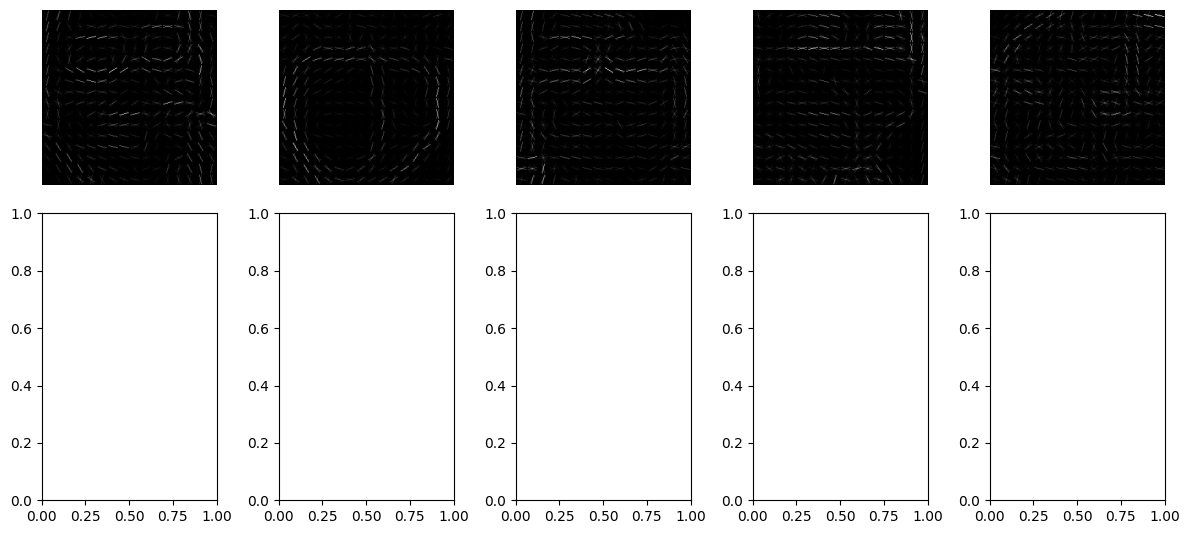

In [ ]:
# Unbalanced problem
# Split the data into training and test sets, stratified by the labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_train)):
    # Load the image and resize to target size
    img = cv2.resize(X_train[i], target_size)

    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))

    # Compute HOG features
    kp, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

    # Show results for first 5 images
    if i < 5:
        row, col = i // 5, i % 5
        ax[row][col].imshow(hog_image, cmap=plt.cm.gray)
        ax[row][col].set_axis_off()

    # Append list of descriptors and label to respective lists
    if kp is not None:
        des_list.append(kp)
        y_train_list.append(y_train[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)

# Training a classifier

In [ ]:
from train_MLP import train_MLP

##############################################################################
# TODO: Implementing classifier                                              #
##############################################################################
classifier = train_MLP(des_array, y_train_list)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

dump(classifier, 'HOG_MLP_Personal_Dataset.joblib') 
classifier = load('HOG_MLP_Personal_Dataset.joblib') 

Iteration 1, loss = 0.96146946
Iteration 2, loss = 0.52144659
Iteration 3, loss = 0.48909029
Iteration 4, loss = 0.46327175
Iteration 5, loss = 0.38692512
Iteration 6, loss = 0.36608312
Iteration 7, loss = 0.30341384
Iteration 8, loss = 0.31151251
Iteration 9, loss = 0.25447531
Iteration 10, loss = 0.21576983
Iteration 11, loss = 0.41621457
Iteration 12, loss = 0.23781448
Iteration 13, loss = 0.22584935
Iteration 14, loss = 0.19538089
Iteration 15, loss = 0.20181060
Iteration 16, loss = 0.13891944
Iteration 17, loss = 0.13271703
Iteration 18, loss = 1.04181015
Iteration 19, loss = 0.79504197
Iteration 20, loss = 0.63006283
Iteration 21, loss = 0.51829180
Iteration 22, loss = 0.68137789
Iteration 23, loss = 0.57441645
Iteration 24, loss = 0.56900866
Iteration 25, loss = 0.56538093
Iteration 26, loss = 0.56441793
Iteration 27, loss = 0.55416728
Iteration 28, loss = 0.49945586
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


# Feature detecting on testing set and classifier implementation

In [ ]:
# Create empty lists for feature descriptors and labels
own_des_list = []
own_y_train_list = []

# Define target size
target_size = (256, 256)

# Loop over each image in the training set
for i in range(len(X_own_test)):
    # Load the image and resize to target size
    img = cv2.resize(X_own_test[i], target_size)

    # Convert to grayscale
    img_gray = img_as_ubyte(color.rgb2gray(img))

    # Compute HOG features
    kp, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)

    # Append list of descriptors and label to respective lists
    if kp is not None:
        own_des_list.append(kp)
        own_y_train_list.append(y_own_test[i])

# Convert to array for easier handling
own_des_array = np.vstack(own_des_list)

In [ ]:
y_pred = classifier.predict(own_des_array)

## Result

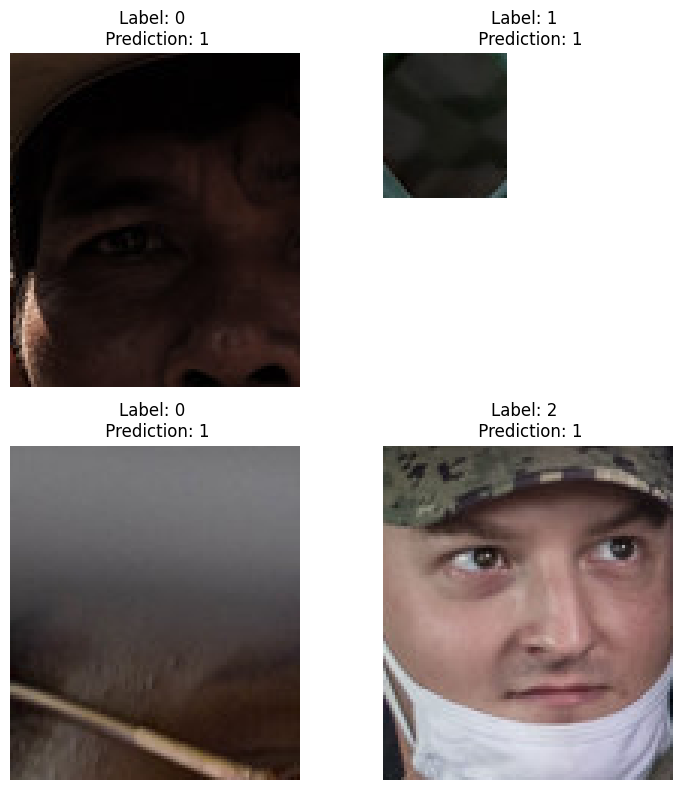

Classification report for classifier MLPClassifier(hidden_layer_sizes=50, learning_rate_init=0.1, max_iter=100,
              random_state=1, solver='sgd', verbose=True):
                    precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      1.00      0.55         9
           2       0.00      0.00      0.00         7

    accuracy                           0.38        24
   macro avg       0.12      0.33      0.18        24
weighted avg       0.14      0.38      0.20        24




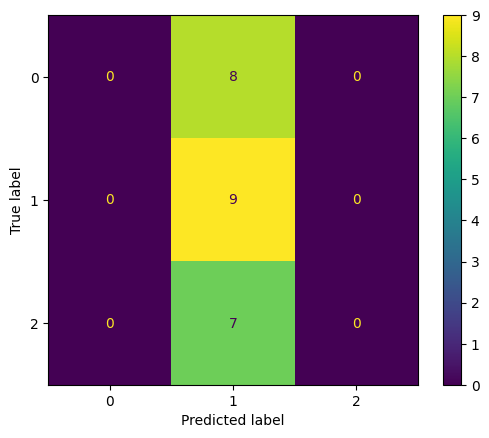

In [ ]:
import numpy as np

# Generate 4 random indices
random_indices = np.random.choice(len(X_own_test), size=4, replace=False)

# Plot the corresponding images
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(X_own_test[idx])
    ax[i].set_title(f'Label: {y_own_test[idx]} \n Prediction: {y_pred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_own_test, y_pred, zero_division=0)}\n""")

metrics.ConfusionMatrixDisplay.from_predictions(y_own_test, y_pred)
plt.show()